## Dataframes 
* Dataframes are a special type of RDDs. 
* Dataframes store two dimensional data, similar to the type of data stored in a spreadsheet. 
   * Each column in a dataframe can have a different type.
   * Each row contains a `record`.
* Similar to, but not the same as, [pandas dataframes](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) and [R dataframes](http://www.r-tutor.com/r-introduction/data-frame)

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext(master="local[4]")
sc.version

'2.2.1'

In [2]:
import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Just like using Spark requires having a SparkContext, using SQL requires an SQLContext
sqlContext = SQLContext(sc)
sqlContext

### Constructing a DataFrame from an RDD of Rows
Each Row defines it's own  fields, the schema is *inferred*.

In [4]:
# One way to create a DataFrame is to first define an RDD from a list of rows
some_rdd = sc.parallelize([Row(name=u"John", age=19),
                           Row(name=u"Smith", age=23),
                           Row(name=u"Sarah", age=18)])
some_rdd.collect()

[Row(age=19, name='John'),
 Row(age=23, name='Smith'),
 Row(age=18, name='Sarah')]

In [5]:
# The DataFrame is created from the RDD or Rows
# Infer schema from the first row, create a DataFrame and print the schema
some_df = sqlContext.createDataFrame(some_rdd)
some_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [7]:
# A dataframe is an RDD of rows plus information on the schema.
# performing **collect()* on either the RDD or the DataFrame gives the same result.
print(type(some_rdd),type(some_df))
print('some_df =',some_df.collect())
print('some_rdd=',some_rdd.collect())

<class 'pyspark.rdd.RDD'> <class 'pyspark.sql.dataframe.DataFrame'>
some_df = [Row(age=19, name='John'), Row(age=23, name='Smith'), Row(age=18, name='Sarah')]
some_rdd= [Row(age=19, name='John'), Row(age=23, name='Smith'), Row(age=18, name='Sarah')]


### Defining the Schema explicitly
The advantage of creating a DataFrame using a pre-defined schema allows the content of the RDD to be simple tuples, rather than rows.

In [8]:
# In this case we create the dataframe from an RDD of tuples (rather than Rows) and provide the schema explicitly
another_rdd = sc.parallelize([("John", 19), ("Smith", 23), ("Sarah", 18)])
# Schema with two fields - person_name and person_age
schema = StructType([StructField("person_name", StringType(), False),
                     StructField("person_age", IntegerType(), False)])

# Create a DataFrame by applying the schema to the RDD and print the schema
another_df = sqlContext.createDataFrame(another_rdd, schema)
another_df.printSchema()
# root
#  |-- age: binteger (nullable = true)
#  |-- name: string (nullable = true)

root
 |-- person_name: string (nullable = false)
 |-- person_age: integer (nullable = false)



## Loading DataFrames from disk
There are many maethods to load DataFrames from Disk. Here we will discuss three of these methods
1. JSON 
2. CSV
3. Parquet

In addition, there are API's for connecting Spark to an external database. We will not discuss this type of connection in this class.

### Loading dataframes from JSON files
[JSON](http://www.json.org/) is a very popular readable file format for storing structured data.
Among it's many uses are **twitter**, `javascript` communication packets, and many others. In fact this notebook file (with the extension `.ipynb` is in json format. JSON can also be used to store tabular data and can be easily loaded into a dataframe.

In [11]:
# when loading json files you can specify either a single file or a directory containing many json files.
path = "../../Data/people.json"
!cat $path 

{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}


In [13]:
# Create a DataFrame from the file(s) pointed to by path
people = sqlContext.read.json(path)
print('people is a',type(people))
# The inferred schema can be visualized using the printSchema() method.
people.show()

people is a <class 'pyspark.sql.dataframe.DataFrame'>
+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [14]:
people.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



### Excercise: Loading csv files into dataframes

Spark 2.0 includes a facility for reading csv files. In this excercise you are to create similar functionality using your own code.

You are to write a class called `csv_reader` which has the following methods:

* `__init__(self,filepath):` recieves as input the path to a csv file. It throws an exeption `NoSuchFile` if the file does not exist.
* `Infer_Schema()` opens the file, reads the first 10 lines (or less if the file is shorter), and infers the schema. The first line of the csv file defines the column names. The following lines should have the same number of columns and all of the elements of the column should be of the same type. The only types allowd are `int`,`float`,`string`. The method infers the types of the columns, checks that they are consistent, and defines a dataframe schema of the form:
```python
schema = StructType([StructField("person_name", StringType(), False),
                     StructField("person_age", IntegerType(), False)])
```
If everything checks out, the method defines a `self.` variable that stores the schema and returns the schema as it's output. If an error is found an exception `BadCsvFormat` is raised.
* `read_DataFrame()`: reads the file, parses it and creates a dataframe using the inferred schema. If one of the lines beyond the first 10 (i.e. a line that was not read by `InferSchema`) is not parsed correctly, the line is not added to the Dataframe. Instead, it is added to an RDD called `bad_lines`.
The methods returns the dateFrame and the `bad_lines` RDD.

### Parquet files
[Parquet](http://parquet.apache.org/) is a columnar format that is supported by many other data processing systems. Spark SQL provides support for both reading and writing Parquet files that automatically preserves the schema of the original data. 

#### More about Parquet
Parquet is a column-based file format and uses disk-resident data structure that support efficient access to subsets of the records. As a result, loading a subset of the records from a Parquet file is much more efficient than loading the same subset of records from a csv or json file. In addition, parquet is compatible with HDFS which further accelerates record retrieval in a distributed system.

In [15]:
dir='../../Data'
parquet_file=dir+"/users.parquet"
!ls $dir

Moby-Dick.txt   OldData         kmeans_data.txt people.json     users.parquet


In [17]:
#load a Parquet file
print(parquet_file)
df = sqlContext.read.load(parquet_file)
df.show()

../../Data/users.parquet
+------+--------------+----------------+
|  name|favorite_color|favorite_numbers|
+------+--------------+----------------+
|Alyssa|          null|  [3, 9, 15, 20]|
|   Ben|           red|              []|
+------+--------------+----------------+



In [18]:
df2=df.select("name", "favorite_color")
df2.show()

+------+--------------+
|  name|favorite_color|
+------+--------------+
|Alyssa|          null|
|   Ben|           red|
+------+--------------+



In [19]:
outfilename="namesAndFavColors.parquet"
!rm -rf $dir/$outfilename
df2.write.save(dir+"/"+outfilename)
!ls -ld $dir/$outfilename

drwxr-xr-x  6 yoavfreund  staff  192 Feb 12 19:01 ../../Data/namesAndFavColors.parquet


A new interface object has been added in **Spark 2.0** called **SparkSession**. A spark session is initialized using a `builder`. For example
```python
spark = SparkSession.builder \
         .master("local") \
         .appName("Word Count") \
         .config("spark.some.config.option", "some-value") \
         .getOrCreate()
```

Using a SparkSession a Parquet file is read [as follows:](http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.parquet):
```python
df = spark.read.parquet('python/test_support/sql/parquet_partitioned')
```

## Loading a dataframe from a pickle file
Here we are loading a dataframe from a pickle file stored on S3. The pickle file contains meterological data that we will work on in future classes.

In [21]:
from os.path import split,join,exists
from os import mkdir,getcwd,remove
from glob import glob

# create directory if needed

notebook_dir=getcwd()
data_dir=join(split(split(notebook_dir)[0])[0],'Data')
weather_dir=join(data_dir,'Weather')

if exists(weather_dir):
    print('directory',weather_dir,'already exists')
else:
    print('making',weather_dir)
    mkdir(weather_dir)

file_index='BBSSBBSS'
zip_file='US_Weather_%s.csv.gz'%file_index #the .csv extension is a mistake, this is a pickle file, not a csv file.
old_files='%s/%s*'%(data_dir,zip_file[:-3])
for f in glob(old_files):
    print('removing',f)
    remove(f)

making /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/Weather


In [23]:
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/small/%s > %s/%s"%(zip_file,data_dir,zip_file)
print(command)
!$command
!ls -lh $data_dir/$zip_file

curl https://mas-dse-open.s3.amazonaws.com/Weather/small/US_Weather_BBSSBBSS.csv.gz > /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/US_Weather_BBSSBBSS.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3350k  100 3350k    0     0  1675k      0  0:00:02  0:00:02 --:--:-- 1595k
-rw-r--r--  1 yoavfreund  staff   3.3M Feb 12 20:16 /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/US_Weather_BBSSBBSS.csv.gz


In [24]:
!gunzip --keep $data_dir/$zip_file
filename='%s/US_Weather_%s.csv'%(data_dir,file_index)
!ls -lh $filename
import pickle
List=pickle.load(open(filename,'rb'))
len(List)

-rw-r--r--  1 yoavfreund  staff    12M Feb 12 20:16 /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/US_Weather_BBSSBBSS.csv


12373

In [26]:
#List is a list of Rows. Stored as a pickle file.
df=sqlContext.createDataFrame(List)
print(df.count())
df.show(1)

12373
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    181.4| 41.0092| -87.8242|       PRCP|USC00111458|     8|[00 00 00 00 00 0...|1991.0|BBSSBBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 1 row



In [27]:
#selecting a subset of the rows so it fits in slide.
df.select('station','year','measurement').show(5)

+-----------+------+-----------+
|    station|  year|measurement|
+-----------+------+-----------+
|USC00111458|1991.0|       PRCP|
|USC00111458|1994.0|       PRCP|
|USC00111458|1995.0|       PRCP|
|USC00111458|1996.0|       PRCP|
|USC00111458|1997.0|       PRCP|
+-----------+------+-----------+
only showing top 5 rows



In [28]:
### Save dataframe as Parquet repository
filename='%s/US_Weather_%s.parquet'%(data_dir,file_index)
!rm -rf $filename
df.write.save(filename)

* Parquet repositories are usually directories with many files.
* Parquet uses its column based format to compress the data.

In [29]:
!du -sh $filename
!du -sh $data_dir/$zip_file

4.2M	/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/US_Weather_BBSSBBSS.parquet
4.1M	/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/US_Weather_BBSSBBSS.csv.gz


## Dataframe operations
Spark DataFrames allow operations similar to pandas Dataframes. We demonstrate some of those.
For more, see [this article](https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/)

In [30]:
df.describe().select('station','elevation','measurement').show()

+-----------+------------------+-----------+
|    station|         elevation|measurement|
+-----------+------------------+-----------+
|      12373|             12373|      12373|
|       null|205.64884021660063|       null|
|       null|170.84234175167742|       null|
|US1ILCK0069|            -999.9|       PRCP|
|USW00014829|             305.1|       TOBS|
+-----------+------------------+-----------+



In [31]:
df.groupby('measurement').agg({'year': 'min', 'station':'count'}).show()

+-----------+---------+--------------+
|measurement|min(year)|count(station)|
+-----------+---------+--------------+
|       TMIN|   1893.0|          1859|
|       TOBS|   1901.0|          1623|
|       TMAX|   1893.0|          1857|
|       SNOW|   1895.0|          2178|
|       SNWD|   1902.0|          1858|
|       PRCP|   1893.0|          2998|
+-----------+---------+--------------+



In [32]:
# THis command will load the python module that defines the SQL functions
#%load ls ~/spark-latest/python/pyspark/sql/functions.py

### Using SQL queries on DataFrames

There are two main ways to manipulate  DataFrames:

#### Imperative manipulation
Using python methods such as `.select` and `.groupby`.
* Advantage: order of operations is specified.
* Disrdavantage : You need to describe both **what** is the result you want and **how** to get it.

#### Declarative Manipulation (SQL)
* Advantage: You need to describe only **what** is the result you want.
* Disadvantage: SQL does not have primitives for common analysis operations such as **covariance**

Spark supports a [subset](https://spark.apache.org/docs/latest/sql-programming-guide.html#supported-hive-features) of the Hive SQL query language.

For example, You can use [Hive `select` syntax](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select) to select a subset of the rows in a dataframe.

To use sql on a dataframe you need to first `register` it as a `TempTable`.

In [33]:
people.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [34]:
# Register this DataFrame as a table.
people.registerTempTable("people")

# SQL statements can be run by using the sql methods provided by sqlContext
teenagers = sqlContext.sql("SELECT name FROM people WHERE age >= 13 AND age <= 19")
for each in teenagers.collect():
    print(each[0])

Justin


#### Counting the number of occurances of each measurement, imparatively

In [35]:
L=df.groupBy('measurement').count().collect()
D=[(e.measurement,e['count']) for e in L]
sorted(D,key=lambda x:x[1], reverse=False)[:6]

[('TOBS', 1623),
 ('TMAX', 1857),
 ('SNWD', 1858),
 ('TMIN', 1859),
 ('SNOW', 2178),
 ('PRCP', 2998)]

#### Counting the number of occurances of each measurement, declaratively.

In [50]:
sqlContext.registerDataFrameAsTable(df,'weather') #using older sqlContext instead of newer (V2.0) sparkSession
query='SELECT measurement,COUNT(measurement) AS count FROM weather GROUP BY measurement ORDER BY count'
print(query)
sqlContext.sql(query).show()

SELECT measurement,COUNT(measurement) AS count FROM weather GROUP BY measurement ORDER BY count
+-----------+-----+
|measurement|count|
+-----------+-----+
|       TOBS| 1623|
|       TMAX| 1857|
|       SNWD| 1858|
|       TMIN| 1859|
|       SNOW| 2178|
|       PRCP| 2998|
+-----------+-----+



#### Performing a map command
In order to perform map, you need to first transform the dataframe into an RDD.

In [51]:
df.rdd.map(lambda row:(row.longitude,row.latitude)).take(5)

[(-87.8242, 41.0092),
 (-87.8242, 41.0092),
 (-87.8242, 41.0092),
 (-87.8242, 41.0092),
 (-87.8242, 41.0092)]

#### Approximately counting the number of distinct elements in column

**Aggregation** can be used to compute statistics of a dataframe

* `count()`, countDistinct(), avg(), max(), min()`

In [71]:
F.max(df.year)

Column<b'max(year)'>

In [68]:
import pyspark.sql.functions as F
F.max(df.year)
#F.approx_count_distinct?
df.agg({'station':'approx_count_distinct','year':'min'}).show()

+---------+------------------------------+
|min(year)|approx_count_distinct(station)|
+---------+------------------------------+
|   1893.0|                           213|
+---------+------------------------------+



#### Approximate Quantile
The method `.approxQuantile` computes the approximate quantiles.

Recall that this is how we computed the pivots for the distributed bucket sort.

In [43]:
print('with accuracy 0.1: ',df.approxQuantile('year', [0.1*i for i in range(1,10)], 0.1))
print('with accuracy 0.01: ',df.approxQuantile('year', [0.1*i for i in range(1,10)], 0.01))

with accuracy 0.1:  [1893.0, 1951.0, 1958.0, 1967.0, 1979.0, 1979.0, 1993.0, 2003.0, 2012.0]
with accuracy 0.01:  [1928.0, 1946.0, 1956.0, 1964.0, 1974.0, 1983.0, 1993.0, 2000.0, 2008.0]


#### Lets collect the exact number of rows for each year
This will take much longer than ApproxQuantile on a large file

In [53]:

# Lets collect the exact number of rows for each year ()
query='SELECT year,COUNT(year) AS count FROM weather GROUP BY year ORDER BY year'
print(query)
counts=sqlContext.sql(query)

SELECT year,COUNT(year) AS count FROM weather GROUP BY year ORDER BY year


In [54]:
A=counts.toPandas()
A.head()

,year,count
0,1893.0,4
1,1894.0,9
2,1895.0,12
3,1896.0,12
4,1897.0,15


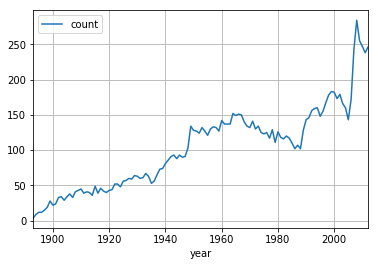

In [55]:
import pandas as pd    
A.plot.line('year','count')
grid()

### Reading rows selectively
Suppose we are only interested in snow measurements. We can apply an SQL query directly to the 
parquet files. As the data is organized in columnar structure, we can do the selection efficiently without loading the whole file to memory.

Here the file is small, but in real applications it can consist of hundreds of millions of records. In such cases loading the data first to memory and then filtering it is very wasteful.

In [58]:
query='SELECT station,measurement,year FROM weather WHERE measurement="SNOW"'
print(query)
df2 = sqlContext.sql(query)
print(df2.count(),df2.columns)
df2.show(5)

SELECT station,measurement,year FROM weather WHERE measurement="SNOW"
2178 ['station', 'measurement', 'year']
+-----------+-----------+------+
|    station|measurement|  year|
+-----------+-----------+------+
|USC00111458|       SNOW|1991.0|
|USC00111458|       SNOW|1994.0|
|USC00111458|       SNOW|1995.0|
|USC00111458|       SNOW|1996.0|
|USC00111458|       SNOW|1997.0|
+-----------+-----------+------+
only showing top 5 rows



## References
* For an introduction to Spark SQL and Dataframes see: [Spark SQL, DataFrames](https://spark.apache.org/docs/latest/sql-programming-guide.html#spark-sql-dataframes-and-datasets-guide)
* Also [spark-dataframe-and-operations](https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/) from [analyticsvidhya.com](https://www.analyticsvidhya.com)

For complete API reference see
* [SQL programming guide](https://spark.apache.org/docs/latest/sql-programming-guide.html) For Java, Scala and Python (Implementation is first in Scala and Python, later pyspark)
* [pyspark API for the DataFrame class](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) 
* [pyspark API for the pyspark.sql module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark-sql-module)


## Exercise
Perform join on two data frames, 
* using .join method 
* using SQL.
